# DQN Basic Implementation


In [119]:
import torch
import torch.nn as nn
import torch.optim as optim
import math, random
import numpy as np
import gym
import matplotlib.pyplot as plt
import os
from collections import deque


In [120]:
# Sett all the libraries with a random seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(seed)
    gym.utils.seeding.np_random(seed)

# Set a seed for all libraries
SEED = 42
set_seed(SEED)


### Environment Exploration

Explore the environment state, action and reward dimension

In [121]:
# Reset environment and get initial state
# Initialize environment
set_seed(SEED)
env_id = "CartPole-v1"
env = gym.make(env_id)

# Print state, action, and observation spaces
print("State space: ", env.observation_space)
print("Action space: ", env.action_space)
print("Observation space: ", env.observation_space)

num_iterations = 3


state, info = env.reset(seed=SEED)
for t in range(num_iterations):

    # Take a random action
    action = np.random.randint(0,env.action_space.n)

    # Take a step in the environment
    next_state, reward, done, truncated, info = env.step(action)

    # Print the next_state, reward, and done
    print("Next State: ", next_state)
    print("Reward: ", reward)
    print("Done: ", done)
    print("Truncation: ", truncated)
    print("Info: ", info)
    


State space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space:  Discrete(2)
Observation space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Next State:  [ 0.02727336 -0.20172954  0.03625453  0.32351476]
Reward:  1.0
Done:  False
Truncation:  False
Info:  {}
Next State:  [ 0.02323877 -0.00714208  0.04272482  0.04248186]
Reward:  1.0
Done:  False
Truncation:  False
Info:  {}
Next State:  [ 0.02309593 -0.20284982  0.04357446  0.34833285]
Reward:  1.0
Done:  False
Truncation:  False
Info:  {}


## Neural Networks

We define our neural networks of interest:

1. DQNNetwork: maps from the state space to Q-values space (one per each action)
2. 

In [122]:
# Define the neural network for Deep Q-Learning
class DQNNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [123]:
# Try the network with a toy state
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
network = DQNNetwork(state_dim, action_dim)

# Create a toy batch of states
state = torch.randn(3, state_dim)

# Get the Q-values from the network
# TODO: The state should be unsqueezed to add a batch dimension
q_values = network(state)

# Print the Q-values
print(q_values.shape)
q_values

torch.Size([3, 2])


tensor([[-0.1497,  0.0344],
        [-0.0549, -0.1398],
        [ 0.0337, -0.0223]], grad_fn=<AddmmBackward0>)

### Experience Replay

Define a class for our Experience Replay

In [124]:
# Define a simple replay buffer

class ExperienceReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    # Add a new experience to the buffer
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    # Function to transform to tensors
    def toTensor(self, states, actions, rewards, next_states, dones):
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long).view(-1, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).view(-1, 1)
        next_states = torch.tensor(next_states, dtype=torch.float32, requires_grad=False)
        dones = torch.tensor(dones, dtype=torch.float32).view(-1, 1)

        return states, actions, rewards, next_states, dones

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        # TODO: Add the conversion to Pytorch tensor here

        return self.toTensor(states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.buffer)


In [125]:
# Test the Experience Replay with a toy example
# Initialize the buffer
buffer = ExperienceReplayBuffer(1000)

# Add a new experience
state = np.array([1, 2, 3, 4])
action = 0
reward = 1
next_state = np.array([5, 6, 7, 8])
done = False
buffer.push(state, action, reward, next_state, done)

# Add another experience
state = np.array([5, 6, 7, 8])
action = 1
reward = 2
next_state = np.array([9, 10, 11, 12])
done = True
buffer.push(state, action, reward, next_state, done)

# Sample a batch from the buffer
batch_size = 2
states, actions, rewards, next_states, dones = buffer.sample(batch_size)

# The experience replay buffer allow us to sample by batches
print("States: ", states, states.shape)
print("Actions: ", actions, actions.shape)
print("Rewards: ", rewards, rewards.shape)
print("Next States: ", next_states, next_states.shape)
print("Dones: ", dones, dones.shape)

States:  tensor([[1., 2., 3., 4.],
        [5., 6., 7., 8.]]) torch.Size([2, 4])
Actions:  tensor([[0],
        [1]]) torch.Size([2, 1])
Rewards:  tensor([[1.],
        [2.]]) torch.Size([2, 1])
Next States:  tensor([[ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.]]) torch.Size([2, 4])
Dones:  tensor([[0.],
        [1.]]) torch.Size([2, 1])


### Agent

Define our Agent class with a train step

In [132]:
# Define the Q-Learning agent
class DQN_Agent:
    def __init__(self, state_dim, action_dim, gamma_td=0.99, lr=0.001):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma_td = gamma_td
        self.lr = lr
        
        # Define the q-network and target q-network
        self.q_network = DQNNetwork(state_dim, action_dim)
        self.target_q_network = DQNNetwork(state_dim, action_dim)

        # Define the optimizer and loss function
        self.optimizer = optim.Adam(list(self.q_network.parameters()), lr=self.lr)
        self.criterion = nn.MSELoss()
        
        self.update_target_network()
    
    def update_target_network(self):
        # Load the weights of the Q-Network
        self.target_q_network.load_state_dict(self.q_network.state_dict())
    
    def select_action(self, state, epsilon):
        # TODO: Check if the random are a proper way to sample 
        # or I should use random from pytorch
        if random.random() < epsilon:
            return random.randint(0, self.action_dim - 1) # NOTE: -1 because randint is inclusive
        else:
            state = torch.FloatTensor(state).unsqueeze(0) # Add batch dimension with unsqueeze(0)
            q_values = self.q_network(state)
            return q_values.argmax().item()
        
    def train(self, replay_buffer, batch_size):                
        # NOTE: At the begining, it's needed some iterations to fill the replay buffer
        if len(replay_buffer.buffer) < batch_size:
            return 0., 0., 0.
        
        # Gather a sample from the replay buffer
        state, action, reward, next_state, done = replay_buffer.sample(batch_size)

        # Calculating the TD-Loss
        # q_values shape: (batch_size, 1) before gathering
        q_values = self.q_network(state).gather(dim = 1, index = action) 

        # next_q_values shape: (batch_size, 1) before max
        next_q_values = self.target_q_network(next_state).max(dim = 1)[0].unsqueeze(1)

        # target_q_values shape: (batch_size, 1)
        target_q_values = reward + (1 - done) * self.gamma_td * next_q_values
        
        # Calculate the TD-Loss
        loss = self.criterion(q_values, target_q_values)
                
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

In [127]:
# Epsilon schedule
# epsilon_start = 1.0
# epsilon_final = 0.01
# epsilon_decay = 500

# epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

# plt.plot([epsilon_by_frame(i) for i in range(10000)])


In [128]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

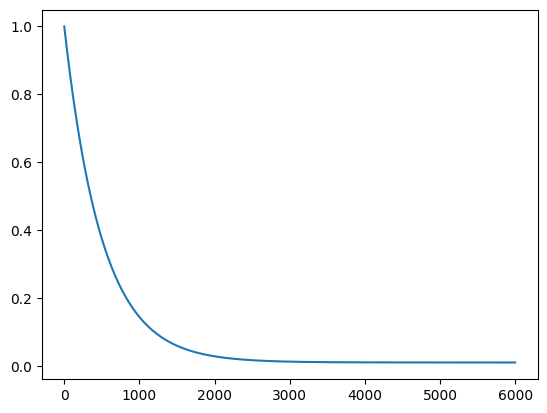

In [129]:
num_iterations = 2000
num_episodes = 3
num_total_steps = num_iterations * num_episodes
plt.plot([epsilon_by_frame(i) for i in range(num_total_steps)])

In [135]:
from torch.utils.tensorboard import SummaryWriter

# Initialize environment
env_id = "CartPole-v1"
env = gym.make(env_id)

# Parameters
gamma_td = 0.99
lr = 0.001
# epsilon = 0.1 # I'm using an schedule now
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
batch_size = 32
capacity = 1000
num_iterations = 2000  # iterations of the game per episode
num_episodes = 3
target_update_frequency = num_iterations
log_interval = 1000  # Log metrics every 1000 iterations
window_size = 100  # For running average

# Initialize agent and replay buffer
agent = DQN_Agent(state_dim, action_dim, gamma_td, lr)
replay_buffer = ExperienceReplayBuffer(capacity)

# Initialize TensorBoard writer
writer = SummaryWriter(f"models/DQN_CartPole-v1_lr_{lr}_gamma_{gamma_td}")

# Metrics storage
episode_rewards = []
iteration_losses = []
running_avg_rewards = []
running_avg_losses = []

steps_done = 0
# Training loop
for episode in range(num_episodes):

    # Reset environment and get initial state
    state, info = env.reset()
    episode_reward = 0
    episode_loss = 0
    episode_length = 0
    done = False
    iteration = 0

    while not done:
        epsilon = epsilon_by_frame(episode * num_iterations + iteration)

        # Choose what action to take with e-greedy policy
        action = agent.select_action(state, epsilon)

        # Take a step in the environment
        next_state, reward, done, _, _ = env.step(action)
        steps_done += 1

        # Add the experience to the replay buffer
        replay_buffer.push(state, action, reward, next_state, done)

        # Train the agent if there are enough experiences
        if len(replay_buffer) >= batch_size:
            loss = agent.train(replay_buffer, batch_size)
            iteration_losses.append(loss)
            episode_loss += loss

            # Track gradient norm
            # for param in agent.q_network.parameters():
            #     writer.add_histogram('Gradients/norm', param.grad.norm(), steps_done)

        state = next_state
        episode_reward += reward
        episode_length += 1
        iteration += 1

        # Update target network periodically
        if steps_done % target_update_frequency == 0:
            agent.update_target_network()

        # Log periodic metrics
        if steps_done % log_interval == 0:
            avg_loss = np.mean(iteration_losses[-log_interval:])
            writer.add_scalar(f'Loss/average_loss_per_{log_interval}_iterations', avg_loss, steps_done)
            # writer.add_scalar('Epsilon', epsilon, steps_done)
            # writer.add_scalar('Max Q-Value', np.max(agent.q_network(torch.FloatTensor(state).unsqueeze(0))), steps_done)
            # writer.add_scalar('Average Q-Value', np.mean(agent.q_network(torch.FloatTensor(state).unsqueeze(0))), steps_done)
            # writer.add_scalar('Replay Buffer Utilization', len(replay_buffer) / capacity, steps_done)

        if done or iteration >= num_iterations:
            break

    # Metrics per episode
    episode_rewards.append(episode_reward)
    avg_episode_loss = episode_loss / episode_length if episode_length > 0 else 0
    running_avg_rewards.append(np.mean(episode_rewards[-window_size:]))
    running_avg_losses.append(np.mean(iteration_losses[-window_size:]))

    # Log metrics
    writer.add_scalar('Reward/episode_reward', episode_reward, episode)
    writer.add_scalar('Loss/average_loss_per_episode', avg_episode_loss, episode)
    # writer.add_scalar('Episode Length', episode_length, episode)
    if len(episode_rewards) >= window_size:
        writer.add_scalar('Reward/running_average_reward', running_avg_rewards[-1], episode)
        writer.add_scalar('Loss/running_average_loss', running_avg_losses[-1], episode)

writer.close()

/home/zosov/anaconda3/envs/rl-project/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/zosov/anaconda3/envs/rl-project/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
